# Projet CSAA - Classification du rythme cardiaque issu d'ECG


Ce jeu de données est composé d'une collections de signaux de battements cardiaques provenant d'un jeu de données célèbres dans le domaine de la classification des battements cardiaques, le jeu de données sur l'arythmie du MIT-BIH.

Les signaux correspondent à des formes d'électrocardiogramme (ECG) de battements cardiaques pour le cas normal et les cas affectés par différentes arythmies et infarctus du myocarde. Ces signaux sont prétraités et segmentés, chaque segment correspondant à un battement cardiaque.

<img src="./Medias/DataECG.png" width="800" height="600">

On distingue 5 battements cardiaques différents : Battements normaux', 'Battements inconnus', 'Battements ectopiques ventriculaires', 'Battements ectopiques supraventriculaires' et 'Battements de fusion'.

De ces signaux, on extrait des caractéristiques par la librairie TSFEL - *Time Series Features Extraction Library* (https://tsfel.readthedocs.io/en/latest/index.html)

Les 156 caractéristiques extraites sont divisées selon les domaines :
- temporel avec 31 caractéristiques comme l'entropie, Max, Min, Absolute Energy ...
- statistique avec 14 caractéristiques comme écart moyen absolu, écart médian, variance, Kurtosis...
- spectral  avec 111 caractéristiques comme les coefficients FFT par bande de fréquence, ondelettes...

Lien vers le papier expliquant TSFEL : https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [1]:
# Librairies utilisées
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Chargement des données d'apprentissage et de test

In [2]:
# Chargement des données d'apprentissage
DataFeatureApp=np.load('./Data/DataApp.npy')
LabelApp=np.load('./LabelApp.npy')
print('Taille de la base d apprentissage :', DataFeatureApp.shape, LabelApp.shape)

# Chargement des données de test
DataFeatureTest=np.load('./Data/DataTest.npy')
LabelTest=np.load('./Data/LabelTest.npy')
print('Taille de la base d apprentissage :', DataFeatureTest.shape, LabelTest.shape)

# Transformation des labels en int, parce que les floats sont nazes
LabelTest = LabelTest.astype(int)
LabelApp = LabelApp.astype(int)

Taille de la base d apprentissage : (5000, 156) (5000,)
Taille de la base d apprentissage : (750, 156) (750,)


# Chargement des variables issues *TSFEL*

In [3]:
ListeVariablesStat=np.load('./Data/ListeVariableStat.npy',allow_pickle=True)
print('Nombre de variables statistiques :',ListeVariablesStat.shape)
#print('Liste Variables Statistiques :', ListeVariablesStat)

ListeVariablesTemps=np.load('./Data/ListeVariableTemps.npy',allow_pickle=True)
print('Nombre de variables temporelles :',ListeVariablesTemps.shape)
#print('Liste Variables Temporelles :',ListeVariablesTemps)

ListeVariablesSpectral=np.load('./Data/ListeVariableSpectral.npy',allow_pickle=True)
print('Nombre de variables spectrales :',ListeVariablesSpectral.shape)
#print('Liste Variables Spectrales :',ListeVariablesSpectral)

Nombre de variables statistiques : (31,)
Nombre de variables temporelles : (14,)
Nombre de variables spectrales : (111,)


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel.

In [4]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels

### Fonctions d'affichage pour les matrices de confusions et les scores de précisions.

In [5]:
def afficherPrecision(mesLabels, string=""):
    # Affiche la précision de labels donnés en paramètre.
    score = metrics.accuracy_score(LabelTest, mesLabels, normalize=True)*100
    print("Score de précision : %.2f" %score, "% | ", string)

    
def genererMatriceConfusion(mesLabels):
    # Génère et renvoi la matrice de confusion des labels donnés en paramètre.
    cm = confusion_matrix(LabelTest, mesLabels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    return disp

def affichage(mesLabels, string = "base"):
    # Méthode pour afficher la matrice de confusion de labels donnés
    
    afficherPrecision(mesLabels)
    disp = genererMatriceConfusion(mesLabels)
    disp.plot()
    
    plt.title("Matrice de confusion de : "+ string)
    plt.tight_layout()
    plt.show()
    
def affichagePlusieursMatrices(mesLabels_array, string_array):
    # Méthode pour afficher la matrice de confusion de labels donnés
    
    size = len(mesLabels_array)
    _, axes = plt.subplots(1, size, figsize=(10, 5))
    
    for i in range(size):
        disp = genererMatriceConfusion(mesLabels_array[i])
        disp.plot(ax=axes[i], colorbar=False)
        axes[i].set_title("Matrice de confusion de " + string_array[i])
        
    plt.tight_layout()
    plt.show()

# Introduction

Dans le cadre de ce Mini-Projet, l'objectif est d'utiliser et de manipuler différentes méthodes supervisées et non supervisées sur un jeu de données et analyser les résultats.

Dans un premier temps nous allons analyser un ensemble de données sans aucun prétraitement, par la suite nous allons effectuer un prétraitement extrêmement basique et enfin nous allons effectuer un prétraitement par ACP.
Dans chaque partie la bibliothèque `scikit-learn` sera utilisée et nous allons dépendre de ses objets et fonctions pour effectuer les classifications de nos données.
Vous trouverez un lien vers la documentation de chaque méthodes utilisées lorsque celle-ci apparaissent

Dans la première partie, pour chaque méthode utilisée, une liste et description des arguments et paramètres possibles est donnés. Après cela une liste des paramètres utilisés et pourquoi est aussi donnée, pour ceux non utilisé cela signifie qu'ils n'avaient aucun impact sur le résultat, ou qu'ils n'étaient pas utilisable dans notre cas, si la raison est plus spécifique, celle-ci sera détaillée.

Pour choisir les méthodes utilisée, je me suis basé sur le schéma suivant. Celui-ci me donne une bonne base de départ. J'ai aussi traversé le cours et la documentation de `scikit-learn` pour trouver d'autres méthodes qui semblerait intéressantes.

<img src="./Medias/SKlearnMap.png" width="800" height="600">

## Partie I : Classification des battements cardiaques sans prétraitement

Classification des battements cardiaques par des méthode d'apprentissage supervisés et des méthode d'apprentissage non supervisés en utilisant la librairie `scikit-learn`.

### I.a Méthodes supervisés  :

Les méthodes supervisés utilisées sont les suivantes :
- K Nearest Neighbors
- Naive Bayes

### K Nearest Neighbors

[NearestNeighbors de scikit-learn](https://scikit-learn.org/1.5/modules/neighbors.html#unsupervised-nearest-neighbors) propose plusieurs configuration pour déterminer le plus proche voisins. 
- n_neighbors : Nombre de plus proches voisins choisis.
- weights : fonctions utilisée dans les prédiction de KNN. Plusieurs choix sont possibles : {`uniform`, `distance`} ou une méthode personnalisée. `uniform` est l'option par défaut.
- algorithm : permet de choisir l'algo utilisé dans la détermination du plus proche voisin. Plusieurs choix sont possible : {`brute`, `kd_tree`, `ball_tree`, `auto`}. Vous pouvez vous référer à cette [documentation](https://scikit-learn.org/1.5/modules/neighbors.html#nearest-neighbor-algorithms) pour les détails de ces algorithmes.
- leaf_size : taille des feuilles pour l'arbre généré avc les algos `kd_tree` et `ball_tree`. L'optimal dépend de la nature du problème.
- p : paramètre utilisé pour la métrique de Minkowski. 1 est équivalent à utiliser Manhattan distance et 2 est équivalent à utiliser Euclidian distance. Si supérieur à 2 alors Minkowski est utilisé.
- metric : `Minkoswki` par défaut, peut être remplacée par une méthode personnalisée et est utilisée pour calculer la distance entre les points.
- metric_params : dictionnaires de mots-clés à ajouter à la fonction de métrique
- n_jobs : nombre de processus parallèle utilisé pour la recherche des KNN. 1 par défaut.

Après avoir effectué des tests avec tous les paramètres pour déterminer un optimal, voici que j'ai pu en tirer comme conclusion : 
- n_neighbors : Le nombre de voisins n'a aucun impact sur le résultat, on n'en retournera donc qu'un seul pour faciliter le traitement du résultat.
- weights : malgré sa présence dans la documentation de KNN, ce paramètre n'existe pas ?... Il se peut que ma version actuelle de sklearn ne soit pas à jour.
- algorithm : Peu importe l'algorithme choisit, cela ne change rien au résultat.
- leaf_size : Ne dépendant que de l'algo `kd_tree` et `ball_tree`, ce paramètre fut testé avec ceux ci et avec diverses valeurs. Le résultat ne changeait pas.
- metric, metric_params : Je n'ai pas pris la peine de créer une méthode personnalisée pour calculer les distances, je suis persuadé que celle utilisée dans la bibliothèque donnera de bien meilleurs résultats.
- p : seul paramètre avec un impact sur le résultat. Après plusieurs test, la valeur optimal est 3. Au dela de celle-ci la précision chute.

Score de précision : 74.80 % |  


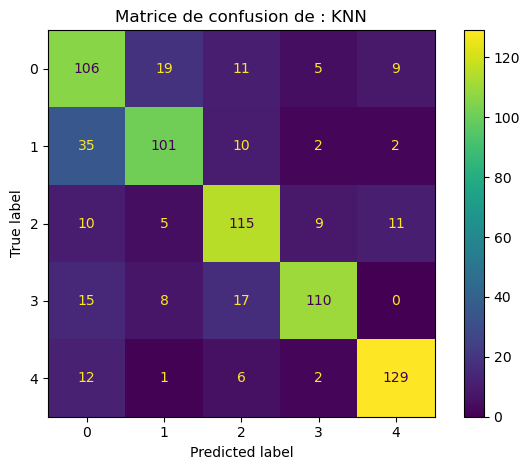

In [6]:
# Première méthode non supervisée : K Nearest Neighbors
from sklearn.neighbors import NearestNeighbors

# Tous les paramètres et leur valeurs sont expliqués plus haut.
def supervised_KNN(Data, Test, p_val=3):
    KNN = NearestNeighbors(n_neighbors=1, p=p_val)
    KNN.fit(Data)

    # Les distances et les indices sont retournés. On se contente de récupérer les indices
    _, indices = KNN.kneighbors(Test)

    # Une petite gymnastique est nécessaire pour pouvoir les utiliser plus facilement
    indices = indices.reshape(1,750)
    indices = indices[0]

    mesLabels_KPPV = np.zeros(750, dtype='int')

    for idx, ind in enumerate(indices):
        mesLabels_KPPV[idx] = LabelApp[ind]
        
    return mesLabels_KPPV

affichage(supervised_KNN(DataFeatureApp, DataFeatureTest), 
          "KNN")

On peut observer que sans pré-traitement, la méthodes des KNN fonctionne plutôt bien. Le score de précision atteint presque les 75% ! Malheureusement, cela sera le meilleur résultat sans pré traitement que nous obtiendrons pour KNN.

### Naive Bayes

Il existe plusieurs variantes de classification bayesienne implémentées par scikit-learn, les seules que j'ai pu utiliser de manière concluantes furent : 
- [Gaussian Naive Bayes](https://scikit-learn.org/1.5/modules/naive_bayes.html#gaussian-naive-bayes)
- [Bernoulli Naive Bayes](https://scikit-learn.org/1.5/modules/generated/sklearn.naive_bayes.BernoulliNB.html#bernoullinb).

Les paramètres de la version Gaussian : 
- priors : Permet d'attribuer un ordre de probabilité de chaque classes. Si existant, celles-ci ne sont pas ajusté aux données.
- var_smoothing : Portion de la variance la plus grande entre toutes les features ajoutée aux calculs de variance pour plus de stabilité. La valeur par défaut est `1e-9`

Les paramètres de la version Bernoulli :
- alpha : paramètre similaire à var_smoothing de GNB. Voir sur [la documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB) pour plus de détails.
- force_alpha : `True` par défaut et force le paramètre alpha à sa valeur par défaut, `1e-10`, si le alpha en donné paramètre inférieur à celle-ci.
- binarize : Taux auquel les valeurs des features sont binarisés. Malheureusement ce paramètre ne prend qu'une valeur en paramètre, on ne peut donc pas faire au cas à cas pour chaque features.
- class_prior : Permet d'attribuer un ordre de probabilité de chaque classes. Si existant, celles-ci ne sont pas ajusté aux données. Il s'agit du même paramètre que la version Gaussienne.

##### Gaussian Naive Bayes

- priors : Après avoir testé différentes probabilités sur chaque classe, aucune n'a permit d'améliorer le résultat.
- var_smoothing : Des valeurs à tout extrême ont été essayés, cependant la seule valeur fournissant une légère augmentation fut `1e-7`.

Score de précision : 66.40 % |  


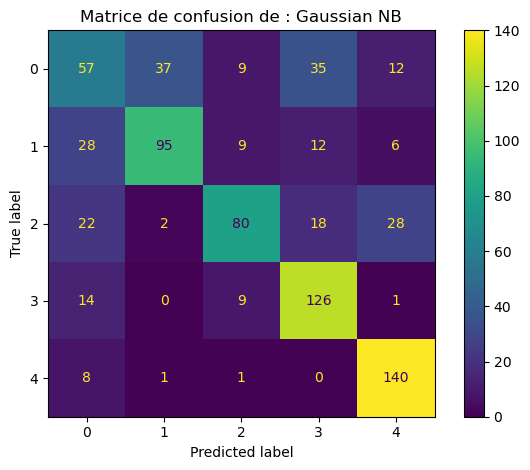

In [7]:
# Seconde méthode supervisée : Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Tous les paramètres et leur valeurs sont expliqués plus haut.
def supervised_GNN(Data, Test, smooth = 1e-7):
    gnb = GaussianNB(var_smoothing=smooth)
    gnb.fit(Data, LabelApp)
    mesLabels_GNB = gnb.predict(Test)

    return mesLabels_GNB

affichage(supervised_GNN(DataFeatureApp, DataFeatureTest), 
          "Gaussian NB")

#### Bernoulli Naive Bayes

Bernoulli est plutôt adapté aux données avec des features booléenne ou qui peuvent être facilement rendus binaire. Cependant avec un résultat que j'ai trouvé plutôt satisfaisant sans aucun prétraitrement, j'ai décidé que cette méthode valait peut-être le coup d'être exploitée.

- alpha et force_alpha : N'améliore pas le résultat, et fait baisser la précision dans le cas d'une puissance positives.
- binarize : Non utilisable dans notre cas.
- class_prior : Même résultat que pour la version gaussienne. Peu importe les priorités d'une classe, le résultat n'est pas amélioré.

Score de précision : 60.00 % |  


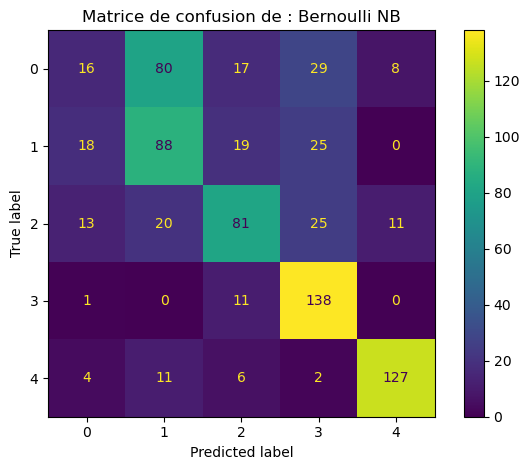

In [8]:
from sklearn.naive_bayes import BernoulliNB

# Tous les paramètres et leur valeurs sont expliqués plus haut.
def supervised_BNB(Data, Test, alpha_val=1e-10):
    bnb = BernoulliNB(alpha=alpha_val)
    bnb.fit(Data, LabelApp)
    mesLabels_BNB = bnb.predict(Test)
    
    return mesLabels_BNB

affichage(supervised_BNB(DataFeatureApp, DataFeatureTest), 
          "Bernoulli NB")

Les méthodes supervisées ont prouvés des résultats moyennement satisfaisant. La meilleure d'entre elle dans notre cas semble être les KNN, qui plafonne à 76.93% de précision.

Nous allons maintenant passer aux méthodes non supervisées pour observer ce que celles-ci peuvent offrir.

### I.b Méthodes non supervisés  :

Les méthodes non supervisés utilisées sont les suivantes :
- K-Means
- Spectral Clustering
- Gaussian Mixture Model

### K-Means

[K-Means de scikit-learn](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html) propose plusieurs paramètres : 
- n_clusters : Le nombre de nombre clusters créés. Celui qui fait le plus de sens est le nombre de labels unique, donc dans notre cas 5.
- init : méthode d'initialisation : celles possibles sont `kmeans++` (par défaut) et `random` pour les centroïdes. Une méthode personnalisée peut aussi être passée en paramètre.
- n_init : La valeur représente le nombre d'itérations effectuées pour le clustering. `auto` par défaut
- max_iter : itérations maximum pour l'algorithme kmeans, 300 par défaut.
- tol : tolérance relative selon la norme de Frobenius. [Lien de la documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html) pour plus d'informations.
- verbose : mode verbose.
- random_state : détermine un nombre aléatoire pour la génération des centroïdes. Utiliser un entier permet de la rendre déterministe.
- copy_x : réalise une copie de nos données d'entraînement, car celle-ci peuvent être légèrement modifiée. True par défaut.
- algorithm : Soit `lloyd` soit `elkan` (`lloyd` par défaut), représente l'algorithme utilisé pour le Kmeans.

Le problème avec Kmeans, est que son résultat change dû à l'initialisation aléatoire des centroïdes, random_state est mit à une valeur prédéterminé, (ici 1) pour garder une consistence lors les tests des paramètres.

- n_clusters : Après de nombreux test, la valeur optimal de clusters se trouve à 40. 
- n_init : Après test, augmenter le nombre d'itération réduit la précision. On laisse le paramètre à `auto`. Si on ne précise pas le paramètre un warning apparaît.
- algorithm : Aucune différence de résultat entre les deux, je l'ai laissé à `elkan`.
- tol : après plusieurs essais, aucune amélioration du résultat.

Score de précision : 25.07 % |  


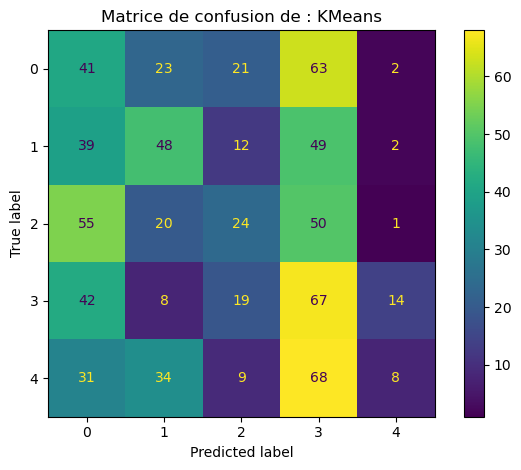

In [9]:
# Première méthode non supervisée : K-Means
from sklearn.cluster import KMeans

# Tous les paramètres et leur valeurs sont expliqués plus haut.
def unsupervised_KMeans(Data, Test, state=1, n=40, algo='elkan'):
    
    kmeans = KMeans(n_clusters=n, n_init='auto', 
                    random_state=state, algorithm=algo)
    kmeans.fit(Data)
    
    app_clusters = kmeans.predict(Data)
    test_clusters = kmeans.predict(Test)
    
    # un peu chiant avec Kmeans ; si on utilise plus de clusters qu'il n'existe
    # de labels unique alors on est obligé de réalisé une correspondances plus poussée
    # des labels de Test.
    label_map = correspondance(app_clusters, LabelApp)
    mesLabels_Kmeans = np.array(label_map[test_clusters])
    
    return mesLabels_Kmeans

affichage(unsupervised_KMeans(DataFeatureApp, DataFeatureTest), 
          "KMeans")

### Gaussian Mixture

[Gaussian Mixture de scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) proposes plusieurs (beaucoup) de paramètres :

- n_components : Nombre de composants
- covariance_type : {`full`, `tied`, `diag`, `spherical`}, type de covariance utilisée pour les paramètres. `full` par défaut.
- tol : taux de convergence. les itérations de EM s'arrêtent si la moyenne de la borne inférieure est en dessous de ce taux.
- reg_covar : régulation des covariances de la matrice, permet de s'assurer qu'ils sont positifs. `1e-6` par défaut
- max_iter : nombre max d'itération de l'algorithme EM réalisé.
- n_init : nombre d'initialisations performées. Seulement les "meilleurs résultats" sont gardés. 1 par défaut.
- init_params : {`kmeans`, `k-means++`, `random`, `random_from_data`}. Méthode utilisée pour l'initialisation des poids, moyennes et précisions. `kmeans` par défaut.
- weigths_init ; poids initiaux fournie par l'utilisateur.
- means_init : moyennes initiales fournie par l'utilisateur.
- precisions_init : précisions initiales fournies par l'utilisateur.
- random_state : Permet de rendre déterministe tous les paramètres utilisant du pseudo-aléatoire.
- warm_start = Si `True`, alors n_init est ignoré et une seule initialisation est faites. Au prochain _fit()_, la solution du précédent fit est utilisée.
- verbose : mode verbose.
- verbose_interval : nombre d'itération avant l'affichage du verbose.

Voici les paramètres gardés et leur impact :
- covariance_type et n_components : étroitement liés, certains sont meilleurs que d'autres. Après plusieurs test, chaque type à son nombre de composant optimal. Au dela de celui-ci la précision baisse ou la fonction crash.
- n_init : maximisé à 10, au dela finit par faire crash la fonction.
- warm_start : Si utilisé atteint le cap de 77.20% après deux fits, cela ne s'améliore pas après.

Score de précision : 76.53 % |  


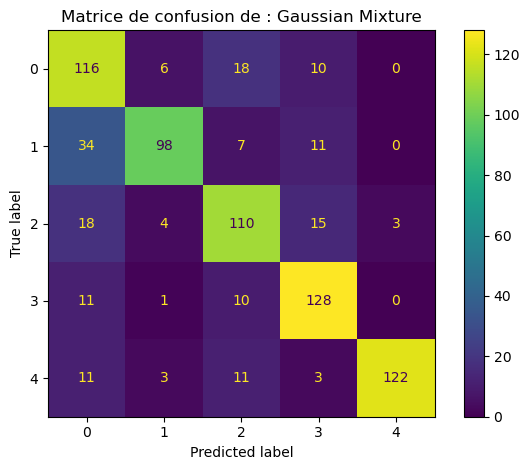

In [10]:
# Troisième méthode non supervisée : Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

# Résultats de l'ensemble des tests de covariance_type et n_components.
# tied = 76% à 43 composants
# full = 57.75% à 10
# diag = 76.53% à 48 <---- Meilleur mais aussi plus rapide, on garde celui-ci
# spherical = 58.93% à 54

# Tous les paramètres et leur valeurs sont expliqués plus haut.
def unsupervised_GaussianMixt(Data, Test, n=48, cov='diag', ni=1, warm_up = False, warm_ite = 2):

    GMM = GaussianMixture(random_state=1, n_components=n, warm_start=warm_up,
                          covariance_type=cov, n_init=ni)
    GMM.fit(Data)
    
    if warm_up is True:
        for _ in range(warm_ite):
            GMM.fit(Data)
    
    indices = GMM.predict(Test)
    mesLabels_GMM = correspondance(indices, LabelTest)

    return mesLabels_GMM

affichage(unsupervised_GaussianMixt(DataFeatureApp, DataFeatureTest), 
          "Gaussian Mixture")

# Partie II : classification des battements cardiaques avec un prétraitement basique

On peut observer que les méthodes non supervisées possèdent une moins bonne précision que les méthodes supervisées. Une des raison à cela peut provenir du manque de pré-traitement effectué sur les données. Dans tous les cas nos résultats avec les méthodes supervisées n'est pas satisfaisant non plus. Nous allons donc effectuer un pré-traitement assez basique pour voir ce que cela peut apporter.

L'objet [StandardScaler de ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) permet d'effectuer un simple pré-traitement sur les données.

In [11]:
from sklearn.preprocessing import StandardScaler

# Le scaler ne possède pas de paramètres affectant ce qu'il renvoi. Donc aucune raison d'y toucher.
scaler = StandardScaler()

# On ne fit que sur nos données de App, puis on les retourne transformées grâce au scaler
scaled_Data = scaler.fit_transform(DataFeatureApp)

# On se contente d'effectuer la transformation sur Test, on ne fit pas dessus.
scaled_Test = scaler.transform(DataFeatureTest)

### II.a Méthodes supervisées.

In [12]:
Labels_supervise = [0] * 3

Labels_supervise[0] = supervised_KNN(scaled_Data, scaled_Test,
                                     p_val=2)
Labels_supervise[1] = supervised_GNN(scaled_Data, scaled_Test,
                                     smooth=1e-3)
Labels_supervise[2] = supervised_BNB(scaled_Data, scaled_Test,
                                        alpha_val=1e-9)


string_supervised = ["KNN", "Gaussian NB", "Bernoulli NB"]

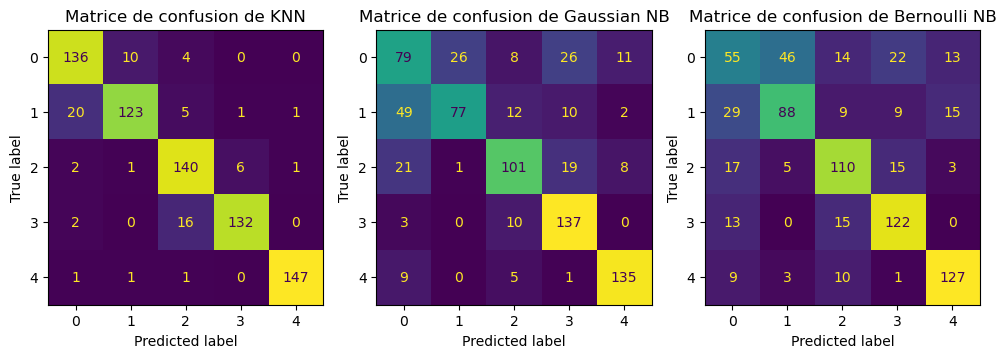

Score de précision : 90.40 % |  KNN
Score de précision : 70.53 % |  Gaussian NB
Score de précision : 66.93 % |  Bernoulli NB


In [13]:
affichagePlusieursMatrices(Labels_supervise, string_supervised)

for i in range(3):
    afficherPrecision(Labels_supervise[i], string_supervised[i])

On observe que toutes les méthodes supervisées ne sont pas toutes traitées pas de la même façon.
Une légère augmentation de précision pour les classifications bayésienne, Bernoulli de 60% à 66.93%, et Gaussian passant de 66.40% à 66.93%

CEPENDANT ! KNN voit sa précision augmenter drastiquement : elle passe de 74.80% à 90.4%.
À cela nous ajoutons de légère modifications sur les paramètres. Après plusieurs tests, ces derniers n'ont rien augmenté de façon drastique.

### II.b Méthodes non supervisées.

Après avoir joué un peu sur les paramètres, la combinaison la plus optimale semblait être celles-ci. Excepté le changement de type de covariance pour Gaussian Mixte, peu change. 

In [14]:
Labels_unsupervised = [0] * 2
Labels_unsupervised[0] = unsupervised_KMeans(scaled_Data, scaled_Test, n=20)
Labels_unsupervised[1] = unsupervised_GaussianMixt(scaled_Data, scaled_Test, n=20, cov='tied')

string_unsupervised = ["Kmeans", "Gaussian Mixes"]

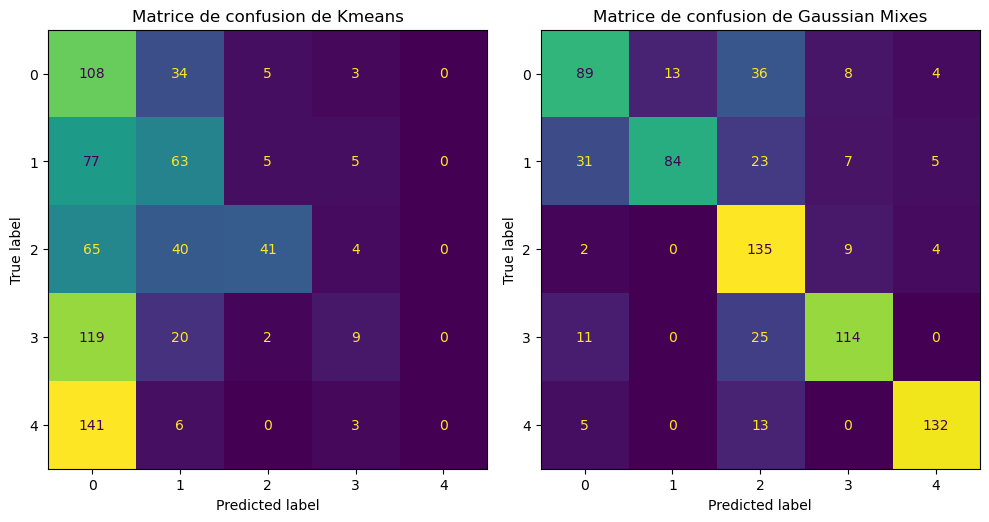

Score de précision : 29.47 % |  Kmeans
Score de précision : 73.87 % |  Gaussian Mixes


In [15]:
affichagePlusieursMatrices(Labels_unsupervised, string_unsupervised)

afficherPrecision(Labels_unsupervised[0], string_unsupervised[0])
afficherPrecision(Labels_unsupervised[1], string_unsupervised[1])

On observe que les résultats pour KMeans sont légèrement meilleur, cependant on ne peut pas en dire autant de Gaussian Mixes.

Pour rappel : Gaussian Mixes est passé de 76.53% à 73.87% et Kmeans de 25.07% à 29.47%.

# Partie III : classification des battements cardiaques avec prétraitement par ACP

Pour cela nous allons utiliser [la décomposotion par PCA de scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#pca). Suite à un problème qui doit venir de ma version de sklearn et ne pouvant régler cela facilement, je n'ai malheureusement pas accès a beaucoup des paramètres donnés pour notre objet PCA. Mes tests seront donc malheureusement limités.

J'ai décidé d'appliquer l'ACP sur les données déjà scaled car cela donnait un résultat nettement meilleur à si l'ACP avait seulement été réalisé sur les données sans pré-traitement.
En jouant un peu sur le nombre de composants de l'ACP, j'ai trouvé après plusieurs tests que `100` était la valeur optimal pour ces derniers.

### III.a Méthodes supervisées.

In [16]:
from sklearn.decomposition import PCA

# Laisser le solveur en auto nous donnait le meilleur résultat. De plus d'après la documentation
# le meilleur solveur serait full, qui doit être celui choisit par 'auto'.
pca = PCA(100 , svd_solver='auto')
pca.fit(scaled_Data)

# On compare nos composantes principales ! 
pca_Data = np.dot(scaled_Data, pca.components_.T)
pca_Test = np.dot(scaled_Test, pca.components_.T)

In [17]:
pca.fit(DataFeatureApp)
test_Data = np.dot(DataFeatureApp, pca.components_.T)
test_Test = np.dot(DataFeatureTest, pca.components_.T)

test_Data = scaler.fit_transform(test_Data)
test_Test = scaler.transform(test_Test)

pca_supervised  = [0] * 3
pca_supervised[0] = supervised_KNN(test_Data, test_Test, p_val=1)
pca_supervised[1] = supervised_GNN(test_Data, test_Test, smooth=1e-9)
pca_supervised[2] = supervised_BNB(test_Data, test_Test)

In [18]:
pca_supervised  = [0] * 3
pca_supervised[0] = supervised_KNN(pca_Data, pca_Test, p_val=1)
pca_supervised[1] = supervised_GNN(pca_Data, pca_Test, smooth=1e-9)
pca_supervised[2] = supervised_BNB(pca_Data, pca_Test)

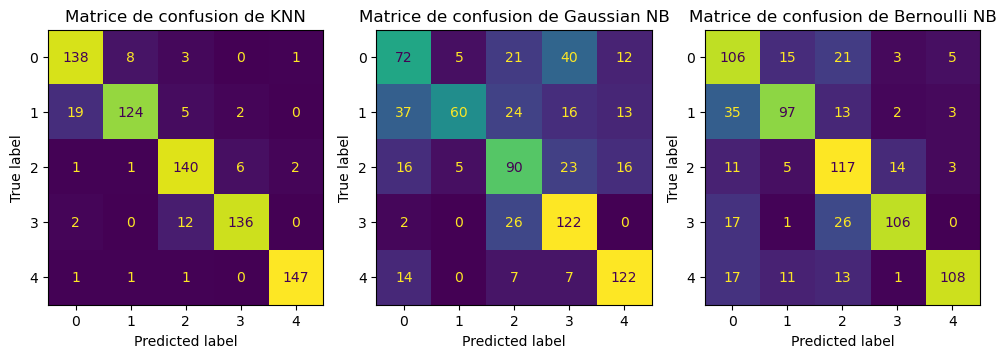

Score de précision : 91.33 % |  KNN
Score de précision : 62.13 % |  Gaussian NB
Score de précision : 71.20 % |  Bernoulli NB


In [19]:
affichagePlusieursMatrices(pca_supervised, string_supervised)

afficherPrecision(pca_supervised[0], string_supervised[0])
afficherPrecision(pca_supervised[1], string_supervised[1])
afficherPrecision(pca_supervised[2], string_supervised[2])

Après avoir de nouveaux joués avec les paramètres, on observe que les résultats ne sont pas très convaincant pour l'ACP. Notre précisions augment légèrement pournos méthodes supervisés, à l'exception de Gaussian NB qui diminue de presque 8% !

Une différence intéressante se trouve dans KNN. Notre valeur de `p` changée, à présent celle-ci utilise les Manhattant distances ! Lors du pré-traitement avec le `scaler`, sa valeur optimal était 2, donc les euclidian distances étaient utilisées. Au final toutes les méthodes de calcul de distances furent utilisées pour KNN avec chacune étant plus optimal dans un cas différent.

### III.b Méthodes non supervisées.

In [20]:
pca_unsupervised  = [0] * 2
pca_unsupervised[0] = unsupervised_KMeans(pca_Data, pca_Test, n=9)
pca_unsupervised[1] = unsupervised_GaussianMixt(pca_Data, pca_Test, n=32, cov='spherical')

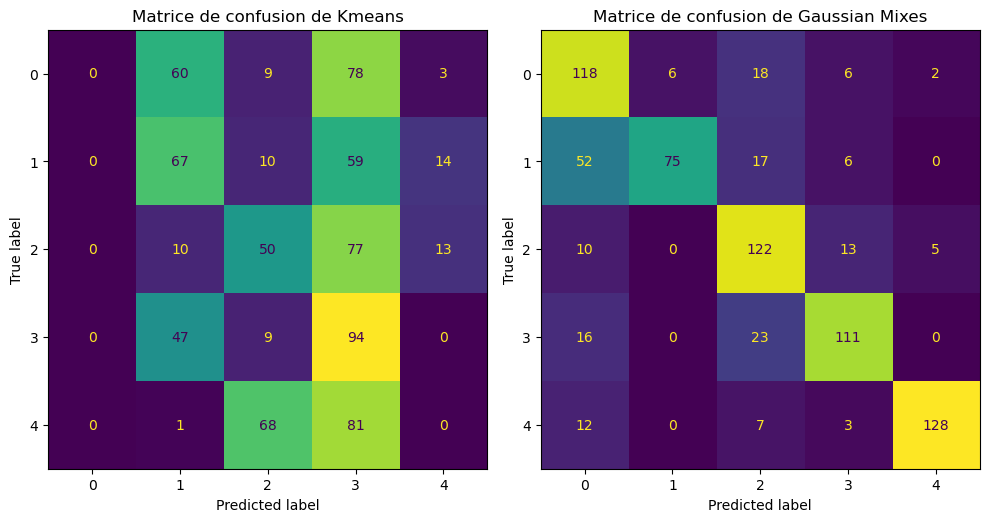

Score de précision : 28.13 % |  Kmeans
Score de précision : 73.87 % |  Gaussian Mixes


In [21]:
affichagePlusieursMatrices(pca_unsupervised, string_unsupervised)

afficherPrecision(pca_unsupervised[0], string_unsupervised[0])
afficherPrecision(pca_unsupervised[1], string_unsupervised[1])

On observe qu'ici aussi la réduction de dimensions par ACP ne change pas grand chose. Malgré le fait que les paramètres optimal de Gaussian Mixes changent, sa précision reste la même que précédemment !
Kmeans lui baisse légèrement.

# Conclusion 

Voici ce que l'on peut conclure avec les observations réalisées plus hautes : l'utilité d'un pré-traitement varie grandement. Dans le cas de KNN celui ci s'est avéré extrêmement utile, faisant grimpé la précision de notre KNN jusque dans les 90% ! Les classifieur bayésien s'en sont même retrouvés à gagner en précision. Ce fut donc un succès dans le cadre de nos méthodes supervisées.

Qu'en est-il des méthodes non supervisées ? Il est vrai que notre méthode Kmeans a gagnée quelque pourcentages de précision, mais pour tout le pré-traitement effectué derrière, est-ce que cela est-il vraiment pertinent ?
Dans le cas de Gaussian Mixture, même si c'est de peu, celui-ci a perdu en précision. Il s'en tirait mieux sans pré-traitement.

Sur le cas du pré-traitement : le plus basique fut réalisé, était aussi le plus efficace. L'ACP nous a fait gagné décimals de pourcentage mais pas de réel augmentation. Si je puis dire, l'ACP fut même presque inutile...
Utiliser l'ACP sur des données non-scalée donnant un résultant encore moins bon que le scaling !
Si jamais, j'ai essayé l'inverse : c'est à dire de réalisé l'ACP puis le scaling après cela. Les résultats étaient en moyenne légèrement moins bon ou ne changeaient pas.

Au final, on peut déduire que chaque problème à une méthode optimale. Dans celle que j'ai pu essayer KNN fut la plus concluante avec plus de 90% de précisions, mais le Gaussian Mixes qui est non supervisés était plus efficace que KNN sans pré-traitement ! Il n'existe pas de solutions parfaite, chacune est plus ou moins adapté à un problème.